Import Dependencies 

In [8]:
# !git clone https://github.com/tmengel/Deep-Learning.git
# %cd Deep-Learning/finalProject
# %pip install uproot
# %pip install pandas

# from google.colab import drive
# drive.mount('/content/drive')

import pulsenet as pn
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
import pandas as pd

File name

In [2]:
filename = "ysoTracesWithPileup.root"
# filename = "/content/drive/MyDrive/DeepLearningFinalProject/ysoTracesWithPileup.root"

Data Preview

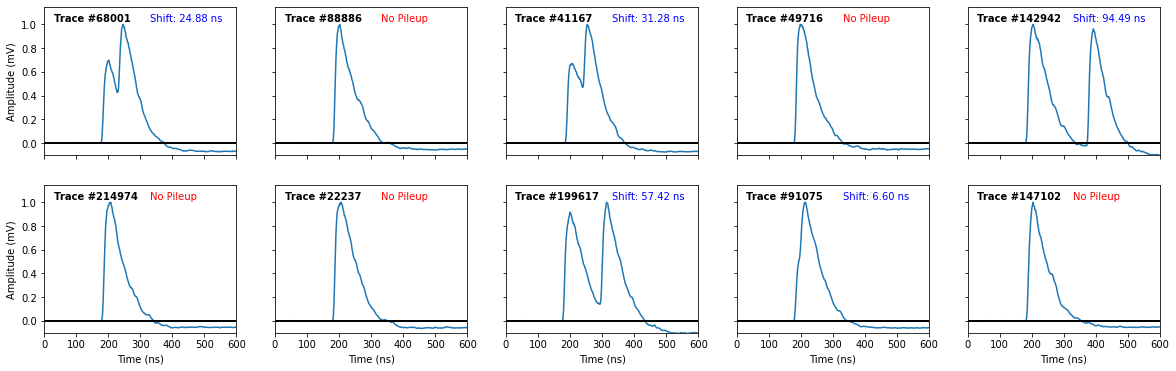

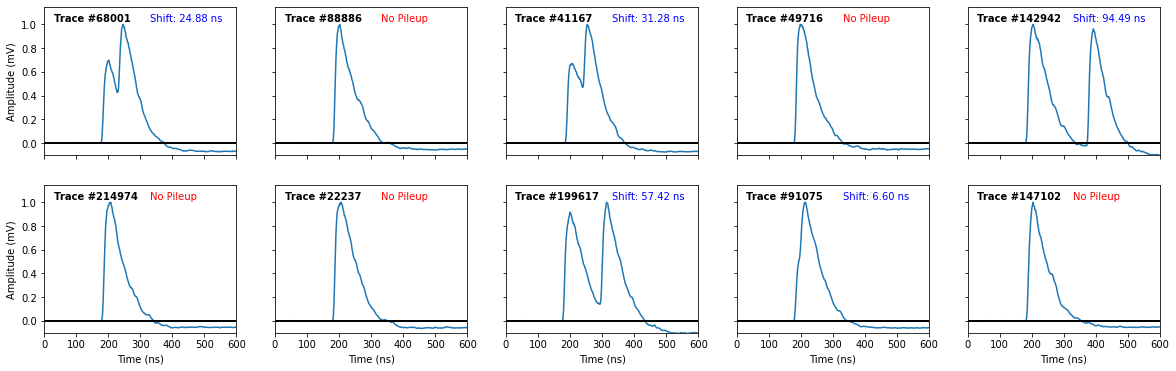

In [3]:
traces, phases, pileup = pn.LoadData(filename)
pn.PlotTraces(traces, phases, pileup, n = 10)

Train All initial Models

**Autoencoder**

In [ ]:
def TrainIndividualModules(model, x, y, weightfile, historyfile, epochs=100, batch_size=128, validation_split=0.2, verbose=1):
    # Train model
    history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
    # Save model weights
    model.layers[0].save_weights(weightfile)
    # Save training history
    pd.DataFrame(history.history, index=history.epoch, columns=history.history.keys()).to_hdf(historyfile, key="hist")

In [ ]:
# Train Discriminator
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=1.0, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)

# output files
weightfile = "weights/discriminator_initial.h5"
historyfile = "history/discriminator_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TraceDiscriminator(name = "trace_discriminator"),
])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train model
TrainIndividualModules(model, x_trace, y_trace, weightfile, historyfile, epochs=100, batch_size=128, validation_split=0.2, verbose=1)

In [ ]:
# Train Phase Classifier
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
y_pileup = pn.EncodePileup(y_phase)
# output files
weightfile = "weights/pileup_classifier_initial.h5"
historyfile = "history/pileup_classifier_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TraceClassifier(name = "pileup_classifier")
])
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

# Train model
TrainIndividualModules(model, x_trace, y_pileup, weightfile, historyfile, epochs=100, batch_size=128, validation_split=0.2, verbose=1)

In [ ]:
# Train Amplitude Regressor
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# output files
weightfile = "weights/amplitude_regressor_initial.h5"
historyfile = "history/amplitude_regressor_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TraceAmplitudeRegressor(name = "amplitude_regressor")
])
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# Train model
TrainIndividualModules(model, y_trace, y_amp, weightfile, historyfile, epochs=100, batch_size=128, validation_split=0.2, verbose=1)

In [ ]:
# Train Phase Regressor
# Get Data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# output files
weightfile = "weights/phase_regressor_initial.h5"
historyfile = "history/phase_regressor_initial_history.h5"

# Create model
model = keras.Sequential([
    pn.TracePhaseRegressor(name = "phase_regressor")
])
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

# Train model
TrainIndividualModules(model, y_trace, y_phase, weightfile, historyfile, epochs=100, batch_size=128, validation_split=0.2, verbose=1)

In [18]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_output = pn.TraceClassifier(name = "pileup_classifier")(input)
trace_discriminator_input = pn.TraceClassifierDiscriminatorHead(name = "trace_discriminator_head")([input, classifer_output])
trace_discriminator_output = pn.TraceDiscriminator(name = "trace_discriminator")(trace_discriminator_input)
phase_output = pn.TracePhaseRegressor(name = "phase_regressor")(trace_discriminator_output)
amplitude_output = pn.TraceAmplitudeRegressor(name = "amplitude_regressor")(trace_discriminator_output)
model = models.Model(inputs=input, outputs=[trace_discriminator_output, phase_output, amplitude_output])
model.compile(optimizer='adam', loss=["mse", "mse", "mse"], metrics=['accuracy'])
model.build(input_shape=(None, 1, 300))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 300)]     0           []                               
                                                                                                  
 trace_classifier (TraceClassif  (None, 1)           199349      ['input_1[0][0]']                
 ier)                                                                                             
                                                                                                  
 trace_discriminator_head (Trac  (None, 300)         306304      ['input_1[0][0]',                
 eClassifierDiscriminatorHead)                                    'trace_classifier[0][0]']       
                                                                                              

In [7]:
pn.TrainModel(x= x_trace, y= y_trace,
              name = "TraceAutoencoder",
              outfile= "trace_autoencoder_only_pileup.h5",
              epochs= 3, batch_size= 128, validation_split= 0.2)
# !cp trace_autoencoder_only_pileup*.h5 /content/drive/MyDrive/DeepLearningFinalProject

Epoch 1/3
1637/1637 [==============================] - 88s 49ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 2/3
1637/1637 [==============================] - 74s 45ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/3
1637/1637 [==============================] - 80s 49ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0018 - val_mse: 0.0018


**Phase, Amplitude, and Classification Models**

In [3]:
# Train Regressors and Classifier on all traces
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
y_pileup = pn.EncodePileup(y_phase)     

Created 261852 samples: 49.969448390693984 % pileup, 50.030551609306016 % no pileup


**Phase Regressor**

In [7]:
pn.TrainModel(x = y_trace, y=y_phase,
              name = "PhaseRegressor",
                outfile="phase_regressor_initial.h5",
                epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/50
1637/1637 [==============================] - 32s 15ms/step - loss: 41.7026 - mean_squared_error: 41.7026 - val_loss: 41.7719 - val_mean_squared_error: 41.7719
Epoch 2/50
1637/1637 [==============================] - 24s 14ms/step - loss: 41.6063 - mean_squared_error: 41.6063 - val_loss: 41.7439 - val_mean_squared_error: 41.7439
Epoch 3/50
1637/1637 [==============================] - 29s 18ms/step - loss: 41.5949 - mean_squared_error: 41.5949 - val_loss: 41.7770 - val_mean_squared_error: 41.7770
Epoch 4/50
1637/1637 [==============================] - 31s 19ms/step - loss: 41.5991 - mean_squared_error: 41.5991 - val_loss: 42.0789 - val_mean_squared_error: 42.0789
Epoch 5/50
1637/1637 [==============================] - 28s 17ms/step - loss: 41.5850 - mean_squared_error: 41.5850 - val_loss: 42.2345 - val_mean_squared_error: 42.2345
Epoch 6/50
1637/1637 [==============================] - 28s 17ms/step - loss: 41.5816 - mean_squared_error: 41.5816 - val_loss: 41.7512 - val_mean_squ

**Amplitude Regressor**

In [4]:
pn.TrainModel(x = y_trace, y=y_amp,
                name = "AmplitudeRegressor",
                outfile="amplitude_regressor_initial.h5",
                epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
1637/1637 [==============================] - 23s 13ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 3.1990e-04 - val_mse: 3.1990e-04
Epoch 2/100
1637/1637 [==============================] - 20s 12ms/step - loss: 4.1717e-04 - mse: 4.1717e-04 - val_loss: 5.8224e-04 - val_mse: 5.8224e-04
Epoch 3/100
1637/1637 [==============================] - 20s 12ms/step - loss: 5.1861e-04 - mse: 5.1861e-04 - val_loss: 3.4552e-04 - val_mse: 3.4552e-04
Epoch 4/100
1637/1637 [==============================] - 19s 12ms/step - loss: 4.3232e-04 - mse: 4.3232e-04 - val_loss: 5.8700e-04 - val_mse: 5.8700e-04
Epoch 5/100
1637/1637 [==============================] - 19s 12ms/step - loss: 5.7243e-04 - mse: 5.7243e-04 - val_loss: 3.3823e-04 - val_mse: 3.3823e-04
Epoch 6/100
1637/1637 [==============================] - 20s 12ms/step - loss: 4.4045e-04 - mse: 4.4045e-04 - val_loss: 3.0220e-04 - val_mse: 3.0220e-04
Epoch 7/100
1637/1637 [==============================] - 22s 13ms/step - loss: 3.2239e-04 

**Classification Model**

In [ ]:
pn.TrainModel(x = x_trace, y=y_pileup,
              name = "PileupClassifier",
                outfile="pileup_classifier_initial.h5",
                epochs=100, batch_size=128, validation_split=0.2)   

**Transfer Learning**
* Transer Autoencoder with Classification Model
* Transfer Autoencoder with Phase Regressor
* Transfer Autoencoder with Amplitude Regressor
* Transfer Autoencoder with Amplitude Regressor and Phase Regressor

In [55]:
# Transfer Learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

class MergeLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MergeLayer, self).__init__(**kwargs)
        self.dense_in = layers.Dense(300, activation='tanh')
        self.dense_mid = layers.Dense(300, activation='tanh')
        self.dense_out = layers.Dense(300, activation='linear')
        
    def call(self, inputs):
        t, c = inputs
        t1, t2 = tf.split(t, 2, axis=1)
        t2 = tf.multiply(tf.reduce_sum(t2, axis=1), c)
        t = tf.concat([t1, tf.expand_dims(t2, axis=1)], axis=1)
        print(t.shape)
        x = self.dense_in(t)
        x = self.dense_mid(x)
        x = self.dense_out(x)
        return x

input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
x = pn.TraceAutoencoder(input) # Trace Autoencoder
c_out = pn.PileupClassifier(input) # Pileup Classifier
trace_out = MergeLayer()([x, c_out]) # Merge Layer
phase_out = pn.PhaseRegressor(trace_out) # Phase Regressor
amp_out = pn.AmplitudeRegressor(trace_out) # Amplitude Regressor

(None, 2, 300)


In [56]:
autoencoder = models.Model(inputs=input, outputs=trace_out)
autoencoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1, 300)]     0           []                               
                                                                                                  
 autoencoder (Sequential)       (None, 2, 300)       419648      ['input_11[0][0]']               
                                                                                                  
 pileup_classifier (Sequential)  (None, 1)           199349      ['input_11[0][0]']               
                                                                                                  
 merge_layer_1 (MergeLayer)     (None, 2, 300)       270900      ['autoencoder[4][0]',            
                                                                  'pileup_classifier[4][0]']

In [54]:
# load data
# x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# declare the model
autoencoder = models.Model(inputs=input, outputs=trace_out)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])
# load the weights from the trained models
print(autoencoder.layers[1].name)
print(autoencoder.layers[4].name)
autoencoder.layers[1].load_weights("trace_autoencoder_only_pileup.h5")
autoencoder.layers[4].load_weights("pileup_classifier_initial.h5")

# make the pileup classifier untrainable
autoencoder.layers[4].trainable = False
autoencoder.layers[1].trainable = False
autoencoder.summary()

# # train the autoencoder
# autoencoder.fit(x_trace, y_trace, epochs=100, batch_size=64, validation_split=0.2)
# # save the weights
# autoencoder.layers[1].save_weights("trace_autoencoder_transfer_from_classifier.h5")

autoencoder
pileup_classifier


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'pileup_classifier_initial.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# load data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# declare the model
autoencoder = models.Model(inputs=input, outputs=phase_out)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])
# load the weights from the trained models
autoencoder.layers[1].load_weights("trace_autoencoder_transfer_from_classifier.h5")
autoencoder.layers[3].load_weights("pileup_classifier_initial.h5")
autoencoder.layers[11].load_weights("phase_regressor_initial.h5")

# make the pileup classifier and phase regressor untrainable
autoencoder.layers[3].trainable = False
autoencoder.layers[11].trainable = False
autoencoder.summary()
# train the autoencoder
autoencoder.fit(x_trace, y_trace, epochs=100, batch_size=64, validation_split=0.2)
# save the weights
autoencoder.layers[1].save_weights("trace_autoencoder_transfer_from_class_and_phase.h5")

In [ ]:
# load data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# declare the model
autoencoder = models.Model(inputs=input, outputs=amp_out)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])
# load the weights from the trained models
autoencoder.layers[1].load_weights("trace_autoencoder_transfer_from_class_and_phase.h5")
autoencoder.layers[3].load_weights("pileup_classifier_initial.h5")
autoencoder.layers[11].load_weights("amplitude_regressor_initial.h5")

# make the pileup classifier and phase regressor untrainable
autoencoder.layers[3].trainable = False
autoencoder.layers[11].trainable = False

autoencoder.summary()
# train the autoencoder
autoencoder.fit(x_trace, y_trace, epochs=100, batch_size=64, validation_split=0.2)
# save the weights
autoencoder.layers[1].save_weights("trace_autoencoder_transfer_from_class_phase_amp.h5")

In [ ]:
# load data
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# declare the model
autoencoder = models.Model(inputs=input, outputs=[phase_out, amp_out])
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])

# load weights from previous autoencoder and regressors
# load the weights from the trained models
autoencoder.layers[1].load_weights("trace_autoencoder_transfer_from_class_phase_amp.h5")
autoencoder.layers[3].load_weights("pileup_classifier_initial.h5")
autoencoder.layers[11].load_weights("phase_regressor_initial.h5")
autoencoder.layers[12].load_weights("amplitude_regressor_initial.h5")

# make the pileup classifier, phase regressor, and amplitude regressor untrainable
autoencoder.layers[3].trainable = False
autoencoder.layers[11].trainable = False
autoencoder.layers[12].trainable = False

autoencoder.summary()

autoencoder.fit(x_trace, [y_phase, y_amp], epochs=100, batch_size=64, validation_split=0.2)
autoencoder.layers[1].save_weights("trace_autoencoder_transfer_learned.h5")

**Fine-Tuning**

In [ ]:
# load data 
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)

autoencoder = models.Model(inputs=input, outputs=[phase_out, amp_out, trace_out])
# decrease learning rate to avoid overfitting
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()]) 

# load weights from previous autoencoder and regressors
# load the weights from the trained models
autoencoder.layers[1].load_weights("trace_autoencoder_transfer_learned.h5")
autoencoder.layers[3].load_weights("pileup_classifier_initial.h5")
autoencoder.layers[11].load_weights("phase_regressor_initial.h5")
autoencoder.layers[12].load_weights("amplitude_regressor_initial.h5")

# make classifier untrainable
autoencoder.layers[3].trainable = False

autoencoder.summary()
# train model on all data
autoencoder.fit(x_trace, [y_phase, y_amp], epochs=50, batch_size=64, validation_split=0.2)
autoencoder.layers[1].save_weights("trace_autoencoder_fine_tuned.h5")
autoencoder.layers[11].save_weights("phase_regressor_fine_tuned.h5")
autoencoder.layers[12].save_weights("amplitude_regressor_fine_tuned.h5")

In [ ]:
# load data 
x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=0.5, phase_min=0, phase_max=20, amplitude_min=0.5, amplitude_max=1.5)
# declare the model
autoencoder = models.Model(inputs=input, outputs=c_out)
# decrease learning rate to avoid overfitting
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryCrossentropy()])

# load weights from previous autoencoder and regressors
# load the weights from the trained models
autoencoder.layers[1].load_weights("trace_autoencoder_fine_tuned.h5")
autoencoder.layers[3].load_weights("pileup_classifier_initial.h5")
autoencoder.layers[11].load_weights("trace_autoencoder_fine_tuned.h5")
autoencoder.layers[12].load_weights("trace_autoencoder_fine_tuned.h5")

# make all but classifier untrainable
autoencoder.layers[1].trainable = False
autoencoder.layers[11].trainable = False
autoencoder.layers[12].trainable = False

autoencoder.summary()
# train model on all data
autoencoder.fit(x_trace, [y_phase, y_amp], epochs=50, batch_size=64, validation_split=0.2)
autoencoder.layers[3].save_weights("pileup_classifier_fine_tuned.h5")